# Forecasting power consumption in Tetouan city using Deep Learning Time Series techniques

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4) 
* [One-step univariate forecasting](#5) 
    * [Timeseries Data Preparation](#6)    
        * [Train - Test split of timeseries dataset](#7)       
    * [Timeseries Model Building](#8)
        * [Data Preprocessing](#9)  
        * [Model Initialization ](#10)
        * [Learning Rate Search ](#11)
    * [Model Training ](#12) 
    * [Power Consumption Forecast & Validation](#13)   
        * [Forecasting Using the trained Timeseries Model](#14)
        * [Estimate model metrics for validation](#15)
    * [Result Visualization](#16)
* [Multi-Step Multivariate Forecasting](#17) 
    * [Timeseries Data Preparation](#18)    
        * [Train - Test split of timeseries dataset](#19)       
    * [Timeseries Model Building](#20)
        * [Data Preprocessing](#21)  
        * [Model Initialization ](#22)
        * [Learning Rate Search ](#23)
    * [Model Training ](#24) 
    * [Power Consumption Forecast & Validation](#25)   
        * [Forecasting Using the trained Timeseries Model](#26)
        * [Estimate model metrics for validation](#27)
    * [Result Visualization](#28)
* [One-Step multivariate forecasting](#29) 
    * [Timeseries Data Preparation](#30)  
        * [Formatting the input dataframe ](#31)
        * [Train - Test split of timeseries dataset](#32)       
    * [Timeseries Model Building](#33)
        * [Data Preprocessing](#34)  
        * [Model Initialization ](#35)
        * [Learning Rate Search ](#36)
    * [Model Training ](#37) 
    * [Power Consumption Forecast & Validation](#38)   
        * [Forecasting Using the trained Timeseries Model](#39)
        * [Estimate model metrics for validation](#40)
    * [Result Visualization](#41)
* [Conclusion](#42)
* [Data resources](#43)

## Introduction <a class="anchor" id="1"></a>

In this notebook we will be forecasting every 10 minutes power consumption for one entire day in Tetouan city using Deep Learning Time Series techniques. This short-term time series forecasting of power consumption in Tetouan city at a 10-minute interval is crucial for optimizing grid operations, enhancing reliability, reducing costs, and facilitating the integration of renewable energy sources. It provides a vital tool for utilities to adapt to changing demand patterns and move towards a more sustainable energy future.

This involves using advanced machine learning models to predict future electricity usage based on historical data. This process can be broken down into different methods and types of models:

Here we will be using different methods of Multi-Step Multivariate Forecasting, One-Step univariate Forecasting, and One-Step Multivariate Forecasting. We will utilize vairous Deep Learning specialized timeseries backbones of InceptionTIme,  Bidirectional LSTM.

## Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from datetime import datetime as dt
from IPython.display import Image, HTML
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot

from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS("home")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a> 

The dataset employed in this illustrative study consists of a multivariate time series comprising power consumption data recorded every 10 minutes in  [Tetouan city.](#43) The data spans from January 2017 to December 2017, encompassing each day within that timeframe. The mulivariates includes historical power consumption, temperature, humidity, wind speed etc. tThe following cell downloads the data:

<Item title:"Tetouan_city_power_consumption1" type:CSV owner:api_data_owner>
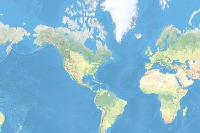

In [3]:
data_table = gis.content.get("c16e532a57bf4900a201dfa5c6e6d1ab")
data_table

In [4]:
# Download the csv and saving it in local folder
data_path = data_table.get_data()

In [5]:
# # Read the csv file
city_power_consumption_df = pd.read_csv(data_path).drop(["Unnamed: 0"], axis=1)
city_power_consumption_df['DateTime'] = pd.to_datetime(city_power_consumption_df['DateTime'])
city_power_consumption_df.head(5)

DateTime  Temperature  Humidity  Wind Speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                  0.051          0.119               34055.69620   
1                  0.070          0.085               29814.68354   
2                  0.062          0.100               29128.10127   
3                  0.091          0.096               28228.86076   
4                  0.048          0.085               27335.69620   

   Zone 2  Power Consumption  Zone 3  Power Consumption  \
0                16128.87538                20240.96386   
1                19375.07599                20131.08434   
2                19006.68693                19668.43373   
3                18361.09422                18899.27711   
4                17872.34043                18442.40964   

   Total Power Consumption    Month weekday  hour  
0              70425.53544  January  Sunday   0.0  
1              69320.84387  January  Sunday   0.0  
2              67803.22193  January  Sunday   0.0  
3              65489.23209  January  Sunday   0.0  
4              63650.44627  January  Sunday   0.0

In [6]:
city_power_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52416 non-null  datetime64[ns]
 1   Temperature                52416 non-null  float64       
 2   Humidity                   52416 non-null  float64       
 3   Wind Speed                 52416 non-null  float64       
 4   general diffuse flows      52416 non-null  float64       
 5   diffuse flows              52416 non-null  float64       
 6   Zone 1 Power Consumption   52416 non-null  float64       
 7   Zone 2  Power Consumption  52416 non-null  float64       
 8   Zone 3  Power Consumption  52416 non-null  float64       
 9   Total Power Consumption    52416 non-null  float64       
 10  Month                      52416 non-null  object        
 11  weekday                    52416 non-null  object        
 12  hour

## One-step univariate forecasting <a class="anchor" id="5"></a> 

First we will be using this apporach which is used as a baseline for more complex forecasting models. In this approach, the model predicts one step ahead at a time. For this study of power consumption, this would mean predicting the usage for the next 10 minute based solely on the historical values of that specific variable up to the current timestep. Thus here using past observations of the single variable named Total Power Consumption we will estimate future values for the given number of future timestep. This method assumes that the future value depends only on the immediate preceding values of the same variable. This approach is relatively straightforward.

### Timeseries Data Preparation<a class="anchor" id="6"></a>   
Data prepration for timeseries consists of first splitting the dataset into train and test as follows:

#### Train - Test split of timeseries dataset <a class="anchor" id="7"></a> 

As suggested earlier, we will forecast power consumption every 10 minutes for an entire day, resulting in 144 data points (6 x 24). To validate the model, we will set aside these 144 data points as the test set, while the remaining data will be used for training.

In [7]:
test_size = 144

In [8]:
city_power_consumption_df.shape

(52416, 13)

In [9]:
train, test = train_test_split(city_power_consumption_df, test_size = test_size, shuffle=False)

In [10]:
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  
52270              67976.01881  December  Friday  23.0  
52271              66688.25950  December  Friday  23.0

In [11]:
# check the columns 
train.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'Total Power Consumption', 'Month', 'weekday', 'hour'],
      dtype='object')

### Model Building <a class="anchor" id="8"></a> 

Once the dataset is divided into the training and test dataset, the training data is ready to be used for modeling.

#### Data Preprocessing <a class="anchor" id="9"></a> 

In this method, we are using a single variable named Total Power Consumption to forecast the 144 timesteps of future total power consumption or electricity usage for every 10 minutes based on its historical data, wihout using any explanatory variables.

The preprocessing of the data is carried out by the `prepare_tabulardata` method from the `arcgis.learn` module in the ArcGIS API for Python. This function will take either a non spatial dataframe, a feature layer or a spatial dataframe containing the dataset as input and will return a TabularDataObject that can be fed into the model. Here we are using a a non spatial dataframe. 

The primary input parameters required for the tool are:

- <span style='background :lightgrey' >input_features</span> : non spatial dataframe, containing the primary dataset 
- <span style='background :lightgrey' >variable_predict</span> : field name `Total Power Consumption` as the y-variable to be forecasted from the input dataframe
- <span style='background :lightgrey' >explanatory_variables</span> : Since there are none in this example, it is not required here. 
- <span style='background :lightgrey' >index_field</span> : field name containing the timestamp

Here preprocessors is used for scaling the data using a scaler as follows, which usually improves the fit of the model.

In [12]:
# one step, univariate
preprocessors = [("Total Power Consumption", MinMaxScaler())] 

data = prepare_tabulardata(train, 
                           variable_predict="Total Power Consumption",
                           index_field="DateTime", 
                           preprocessors=preprocessors)

C:\Users\Supratim\AppData\Local\ESRI\conda\envs\certifica2.2_5sep23\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



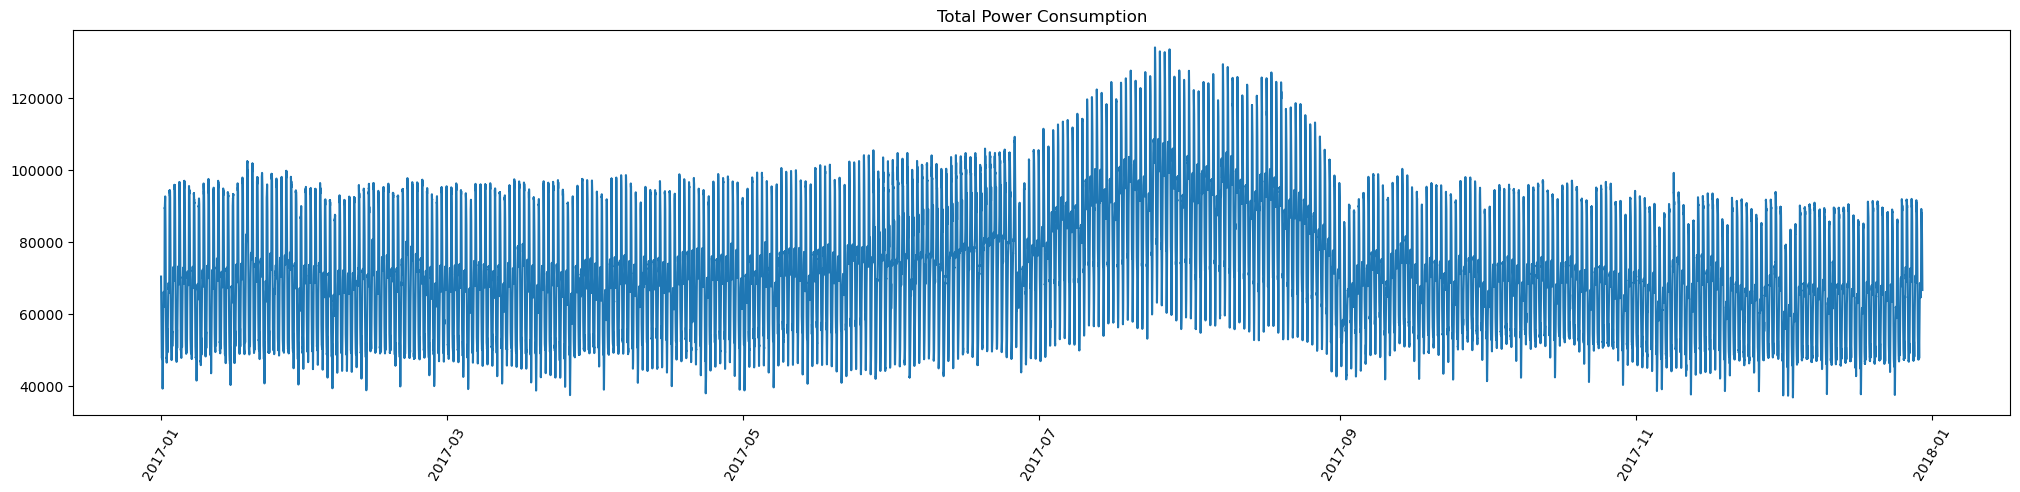

In [13]:
# Visualize the entire timeseries data
data.show_batch(graph=True)

In [14]:
data.show_batch()

Total Power Consumption
19770              53258.85754
28061             116044.38323
33214              91241.08204
34775              76922.19575
50228              86624.92361

Here sequence length of 288 is used which is previous two days of power consumption data. This is an important parameter for fitting a timeseries forecasting model and usually indicates the seasonality of the data, which could be experimented with for a better fit. 

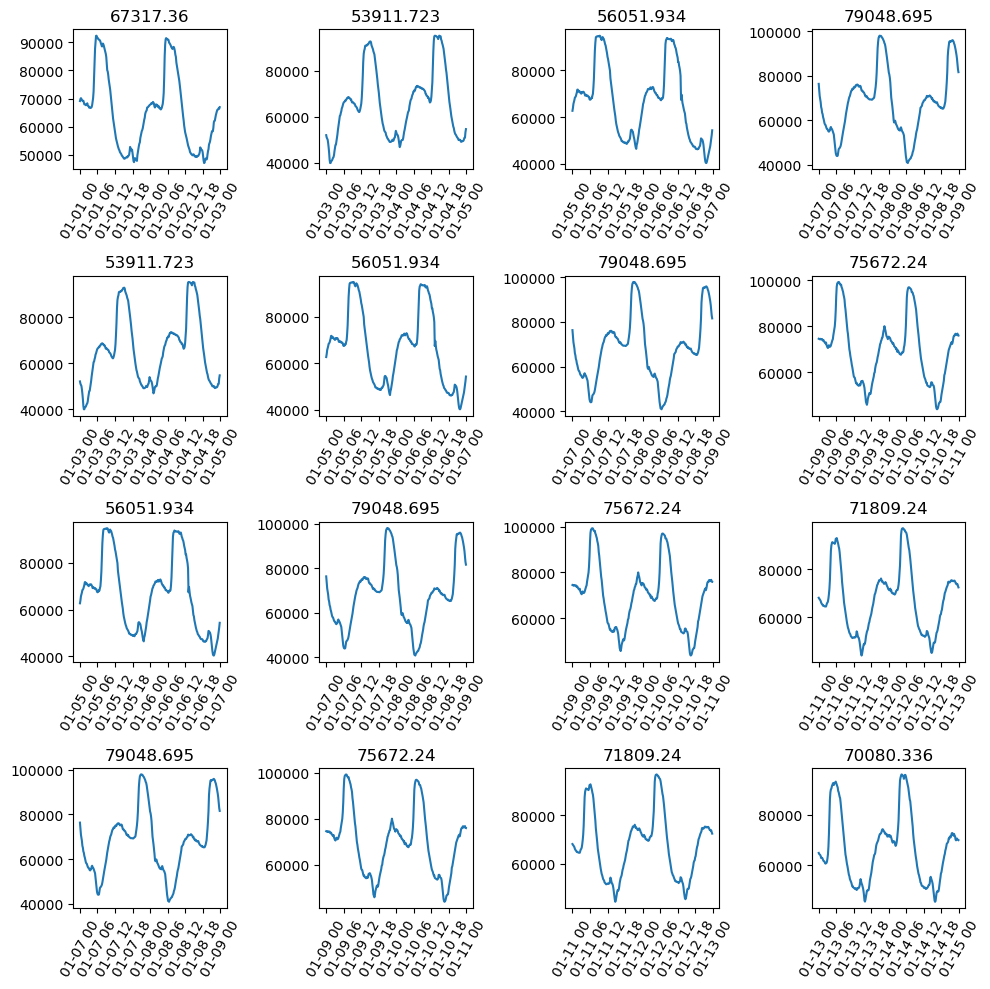

In [15]:
# visualize the timeseries in batches
seq_len = 288
data.show_batch(rows=4,seq_len=seq_len)

#### Model Initialization <a class="anchor" id="10"></a>

This is the most significant step for fitting a timeseries model. Here, along with the preprocesed data, the backbone for training the model and the sequence length are passed as parameters. Out of these three, the sequence length has to be selected carefully, since it is a critical paramters. The sequence length is usually the cycle of the data, and you can check with higher sequence length if there is sufficient computing resources area available. 

In terms of backbones the available set of backbones encompasses various architectures specialized for handling time series data. These include models specifically designed for time series (InceptionTime, TimeSeriesTransformer), recurrent neural networks like LSTM and Bidirectional LSTM, Neural network (FCN), and adaptations of convolutional neural networks (ResNet, ResCNN) for effective time series analysis.

Here the `LSTM Bidirectional` is selected from the above.

In [16]:
# In model initialization, the data and the backbone is selected 
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='LSTM',bidirectional=True)

#### Learning Rate Search <a class="anchor" id="11"></a>

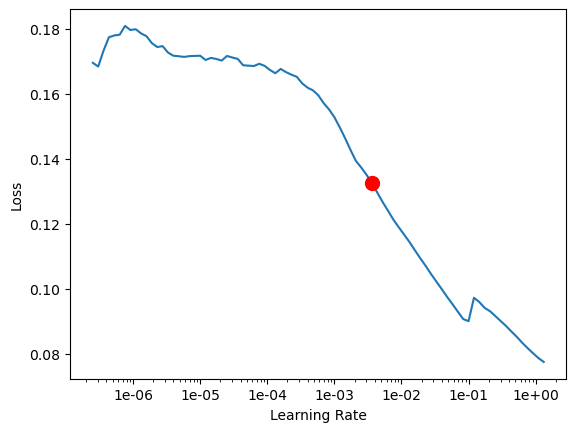

In [17]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()

### Model Training <a class="anchor" id="12"></a>

Finally, the model is now ready for training. To train the model, the `model.fit` is called and provided with the number of epochs for training and the estimated learning rate suggested by `lr_find` in the previous step. Here we will use only 2 epochs for training. You can increase the epochs and train it more:

In [18]:
ts_model.fit(2, lr=l_rate, early_stopping=True)

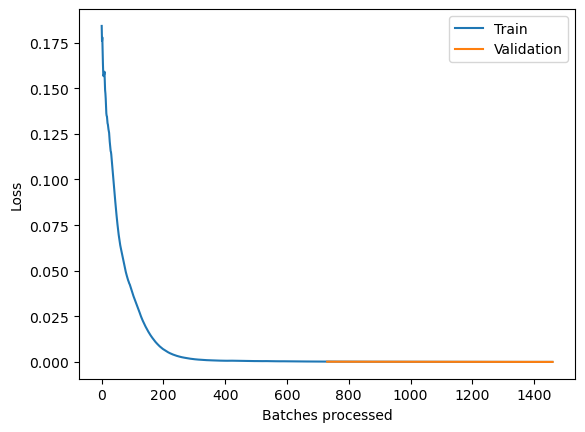

In [19]:
# the train vs valid losses is plotted to check quality of the trained model, and whether the model needs more training
ts_model.plot_losses()

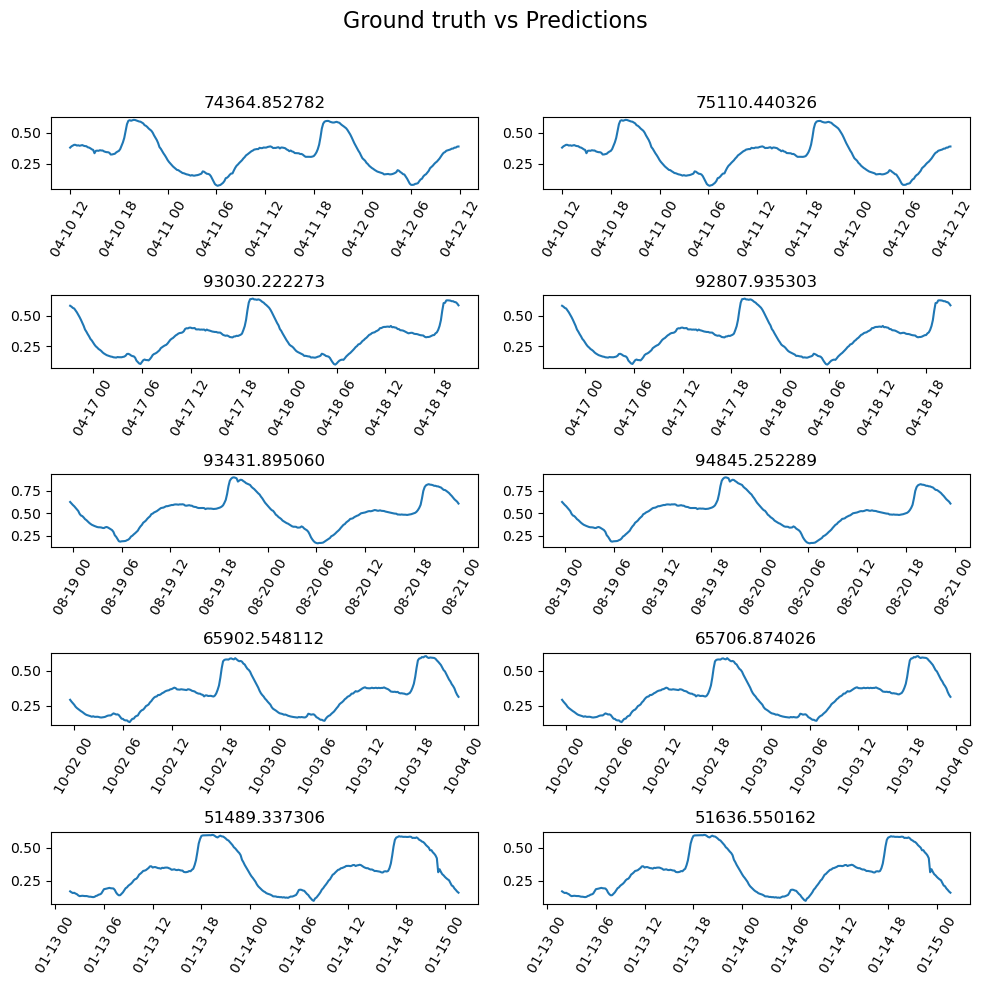

In [20]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

The show result above reveals the ground truth are close to the forecasted vlaues by the trained model indicating a good fit. This is further validated by checking the model score.

In [21]:
# check the trained model score
ts_model.score()

0.9977096062381238

### Power Consumption Forecast & Validation using one-step <a class="anchor" id="13"></a>

#### Forecasting Using the trained Timeseries Model <a class="anchor" id="14"></a>

Finally the predict function is used to forecast for a period of the next 144 time steps after the last recorded time steps in the training dataset. Thus during forecasting the model will use the same training data set as input and will use the last sequence length number of terms from its tail to predict the user given number of future prediction, which is 144. So it will forecast for the day of 30th December, at every 10 minutes power consumption, starting on  00:00, 00:10, 00:20 etc till 23:50 of the same day. 

In [22]:
# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'  
sdf_forecasted_univar = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)

In [23]:
# checking the final forecasted result returned by the model
sdf_forecasted_univar.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52414  2017-12-30 23:40          NaN       NaN         NaN   
52415  2017-12-30 23:50          NaN       NaN         NaN   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52414                    NaN            NaN                       NaN   
52415                    NaN            NaN                       NaN   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52414                        NaN                        NaN   
52415                        NaN                        NaN   

       Total Power Consumption Month weekday  hour  \
52414                      NaN   NaN     NaN   NaN   
52415                      NaN   NaN     NaN   NaN   

       Total Power Consumption_results  
52414                     68133.300635  
52415                     66690.633232

#### Estimate model metrics for validation <a class="anchor" id="15"></a>

The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 144 time steps set aside at the beginning.

In [24]:
# Formating the forecasted result into actual vs the predicted columns
sdf_forecasted = sdf_forecasted_univar.tail(test_size).copy()
sdf_forecasted = sdf_forecasted[['DateTime','Total Power Consumption_results']]
sdf_forecasted['Actual_Total Power Consumption'] = test['Total Power Consumption'].values
sdf_forecasted = sdf_forecasted.set_index(sdf_forecasted.columns[0])
sdf_forecasted.head()

Total Power Consumption_results  \
DateTime                                            
2017-12-30 00:00                     64942.373507   
2017-12-30 00:10                     63477.082540   
2017-12-30 00:20                     62063.954682   
2017-12-30 00:30                     60689.115871   
2017-12-30 00:40                     59404.952782   

                  Actual_Total Power Consumption  
DateTime                                          
2017-12-30 00:00                     65061.74921  
2017-12-30 00:10                     63079.20846  
2017-12-30 00:20                     61256.28975  
2017-12-30 00:30                     60136.79086  
2017-12-30 00:40                     58771.21664

In [25]:
sdf_forecasted.shape

(144, 2)

In [26]:
# Bi-LSTM
r2_test = r2_score(sdf_forecasted['Actual_Total Power Consumption'],sdf_forecasted['Total Power Consumption_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.94


A considerably high r-squared value indicates a high similarity between the forecasted and the actual sales values.

### Result Visualization <a class="anchor" id="16"></a>

Finally, for a better understanding of the trained model, the actual and forecasted values are plotted to visualize their distribution over the enitre period of 144 timestesp, with the blue lines indicating forecasted values and orange line showing the actual values. It allows us to visually inspect how well the forecasted values align with the observed data. This helps in quickly assessing the accuracy of the forecasting model.

In [27]:
sdf_forecasted.head(2)

Total Power Consumption_results  \
DateTime                                            
2017-12-30 00:00                     64942.373507   
2017-12-30 00:10                     63477.082540   

                  Actual_Total Power Consumption  
DateTime                                          
2017-12-30 00:00                     65061.74921  
2017-12-30 00:10                     63079.20846

In [28]:
#sdf_forecasted = sdf_forecasted.reset_index()
sdf_forecasted['DateTime'] = (sdf_forecasted.index).to_timestamp()
sdf_forecasted.set_index('DateTime', inplace=True)

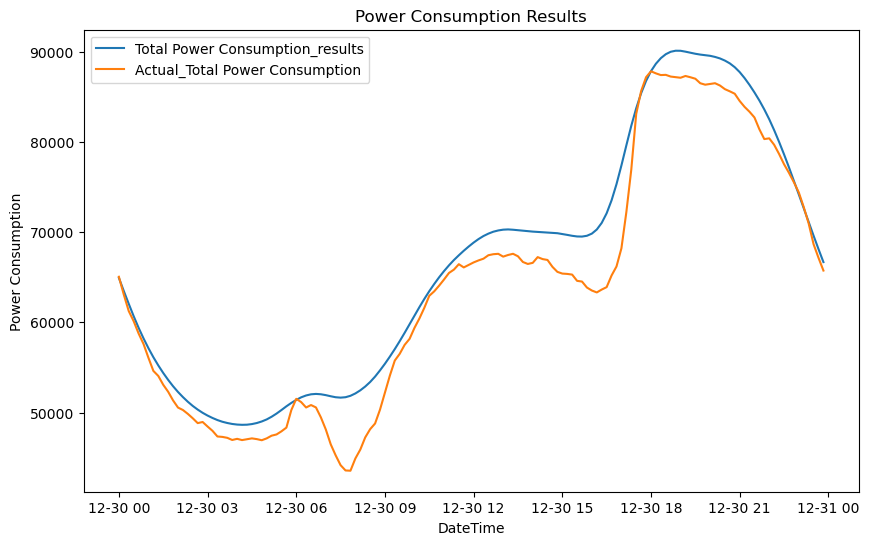

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(sdf_forecasted.index, sdf_forecasted['Total Power Consumption_results'], label='Total Power Consumption_results')
plt.plot(sdf_forecasted.index, sdf_forecasted['Actual_Total Power Consumption'], label='Actual_Total Power Consumption')
plt.xlabel('DateTime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Results')
plt.legend()
plt.show()

This is considerably good forecast considering it's a univariate time series forcaste covering 144 future timesteps. Let's explore if we can further enhance this outcome by incorporating multivariate data and employing additional methods.

## Multi-Step Multivariate Forecasting <a class="anchor" id="17"></a>

Multivariate forecasting approach involves using multiple time series variables (e.g., historical power consumption, temperature, humidity, etc.) to make predictions. This allows the model to capture more complex relationships and dependencies but can be more computationally intensive. Multi-Step forecasting method involves predicting multiple future time steps at once. For instance, forecasting the power consumption for the next several timestep simultaneously.

Here the Multi-Step Multivariate Forecasting method combines both the multi-step and multivariate approaches, where multiple future time steps are forecasted using a model using multiple explanatory variables.

### Timeseries Data Preparation <a class="anchor" id="18"></a>   
Data prepration for timeseries consists of first splitting the dataset into train and test as follows:

#### Train - Test split of timeseries dataset <a class="anchor" id="19"></a>

As explained earlier, we will set aside the 144 (6 x 24) data points as the test set, while the remaining data will be used for training.

In [30]:
test_size = 144

In [31]:
city_power_consumption_df.shape

(52416, 13)

In [32]:
train, test = train_test_split(city_power_consumption_df, test_size = test_size, shuffle=False)

In [33]:
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  
52270              67976.01881  December  Friday  23.0  
52271              66688.25950  December  Friday  23.0

In [34]:
test.head(2)

DateTime  Temperature  Humidity  Wind Speed  \
52272 2017-12-30 00:00:00        13.17     52.67       0.077   
52273 2017-12-30 00:10:00        13.07     52.67       0.077   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52272                  0.062          0.126               27692.77567   
52273                  0.037          0.111               26792.39544   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52272                24611.23044                 12757.7431   
52273                23874.80822                 12412.0048   

       Total Power Consumption     Month   weekday  hour  
52272              65061.74921  December  Saturday   0.0  
52273              63079.20846  December  Saturday   0.0

In [35]:
train.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'Total Power Consumption', 'Month', 'weekday', 'hour'],
      dtype='object')

### Model Building <a class="anchor" id="20"></a>

Once the dataset is divided into the training and test dataset, the training data is ready to be used for modeling.

#### Data Preprocessing <a class="anchor" id="21"></a>

Now here we will be using additional multivariates of Temperature, Humidity, Wind Speed, general diffuse flows, diffuse flows, combined with related datetime information of month, weekday, and hour. Out of these month and weekday are used as categorical variables. And as earlier we wil forecast the 144 timesteps of future total power consumption or electricity usage for every 10 minutes based on its historical data, using these explanatory variables.

The preprocessing of the data is similarly done by the prepare_tabulardata method from the arcgis.learn module in the ArcGIS API for Python. 

Here the additional parameter  `explanatory_variables` will be used along with the earlier used paramtersas follows:

This function will take either a non spatial dataframe, a feature layer or a spatial dataframe containing the dataset as input and will return a TabularDataObject that can be fed into the model. Here we are using a a non spatial dataframe.

The additional input parameters required for the tool is:

    explanatory_variables : We will pass the selected multiple variables in a list, along with declaring the relevant categorical variables    

Here preprocessors is used for scaling the data using a scaler, which usually improves the fit of the model.

In [36]:
# multistep multivariate
preprocessors = [("Temperature","Humidity","Wind Speed","general diffuse flows","diffuse flows",
                  "Total Power Consumption", MinMaxScaler())]
data = prepare_tabulardata(train, 
                           variable_predict="Total Power Consumption",                           
                           explanatory_variables=["Temperature","Humidity","Wind Speed",
                                                  "general diffuse flows","diffuse flows",('Month',True),
                                                  ('weekday',True), 'hour'],
                           index_field="DateTime", preprocessors=preprocessors)

C:\Users\Supratim\AppData\Local\ESRI\conda\envs\certifica2.2_5sep23\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



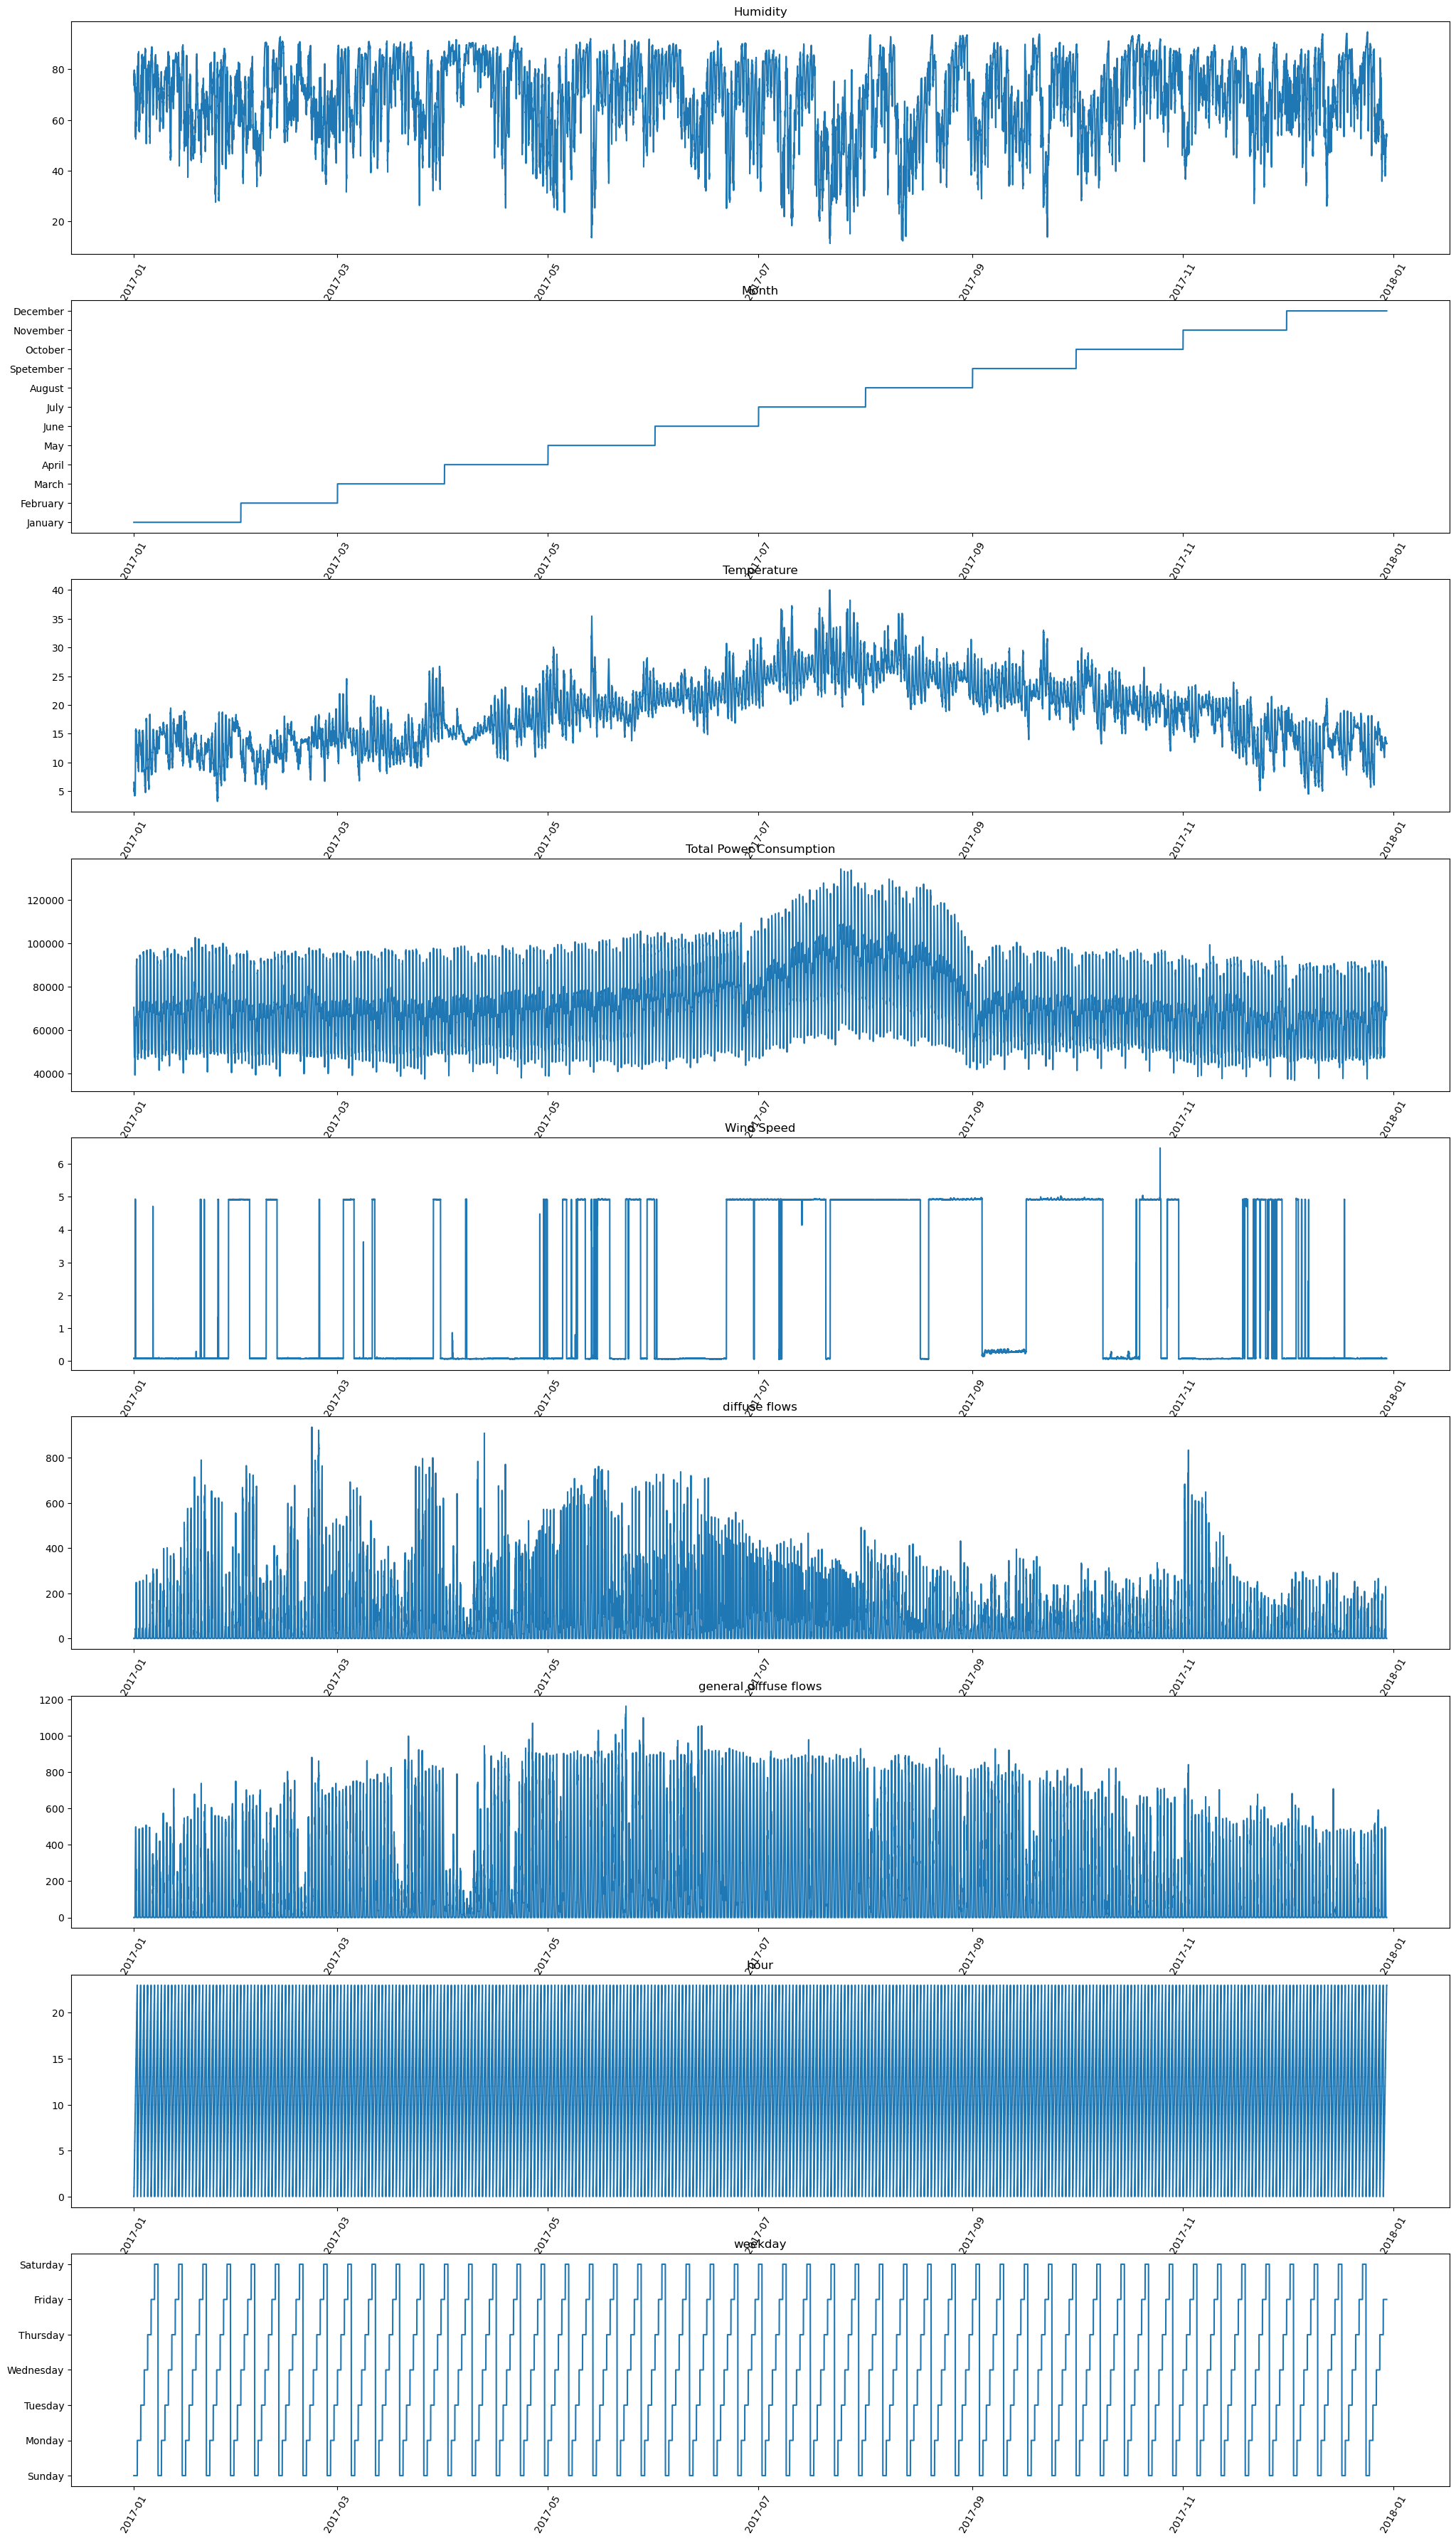

In [37]:
# Visualize the data distibution of all the variables 
data.show_batch(graph=True)

In [38]:
data.show_batch()

Humidity     Month  Temperature  Total Power Consumption  Wind Speed  \
19770      78.8       May        18.86              53258.85754       4.916   
28061      77.2      July        25.66             116044.38323       4.913   
33214      71.8    August        27.75              91241.08204       4.923   
34775      81.0    August        27.23              76922.19575       4.920   
50228      70.6  December        15.00              86624.92361       0.082   

       diffuse flows  general diffuse flows  hour    weekday  
19770         85.300                 94.800   7.0   Thursday  
28061          0.207                  0.234  20.0     Friday  
33214        163.800                700.000  15.0   Saturday  
34775        244.300                398.200  11.0  Wednesday  
50228          0.145                  0.051  19.0     Friday

Here sequence length is the used as same as earlier, of 288, which is previous two days of power consumption data.

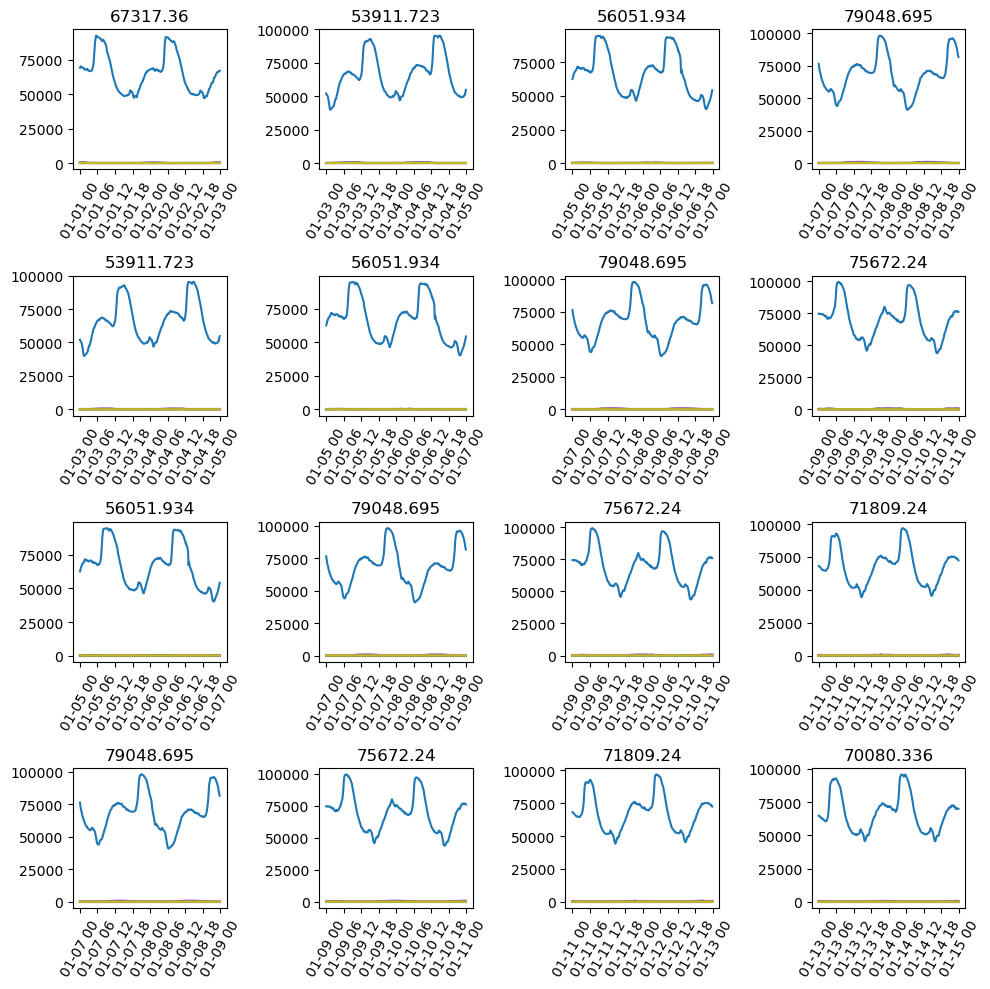

In [39]:
# half of seq len to be predicted, so if the test size is 144, then 288 should be seq len
seq_len = 288
data.show_batch(rows=4,seq_len=seq_len)

#### Multi-step Model Initialization <a class="anchor" id="22"></a>

Here along with the earlier used paramter of data, sequence length and model architecture, we will pass the additional paramter of `multistep=True` for initializing the model. For the model architecture we will use InceptionTime which is a specifically designed backbone for time series.

In [40]:
# multistep
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='InceptionTime',multistep=True)

#### Learning Rate Search <a class="anchor" id="23"></a>

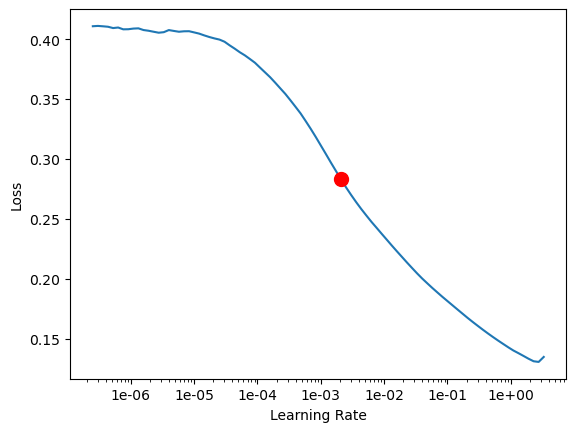

In [41]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()

### Model Training <a class="anchor" id="24"></a>

Finally, the model is now ready for training. To train the model, the model.fit is called and provided with the number of epochs for training and the estimated learning rate suggested by lr_find in the previous step. As previously, used we will train it for  epochs. You can increase the epochs and train it more.

In [42]:
ts_model.fit(2, lr=l_rate, early_stopping=True)

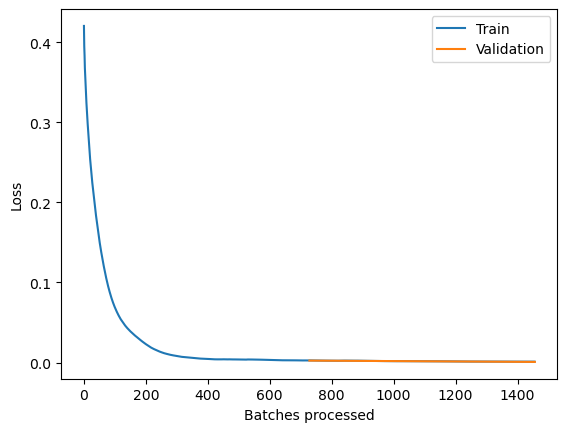

In [43]:
ts_model.plot_losses()

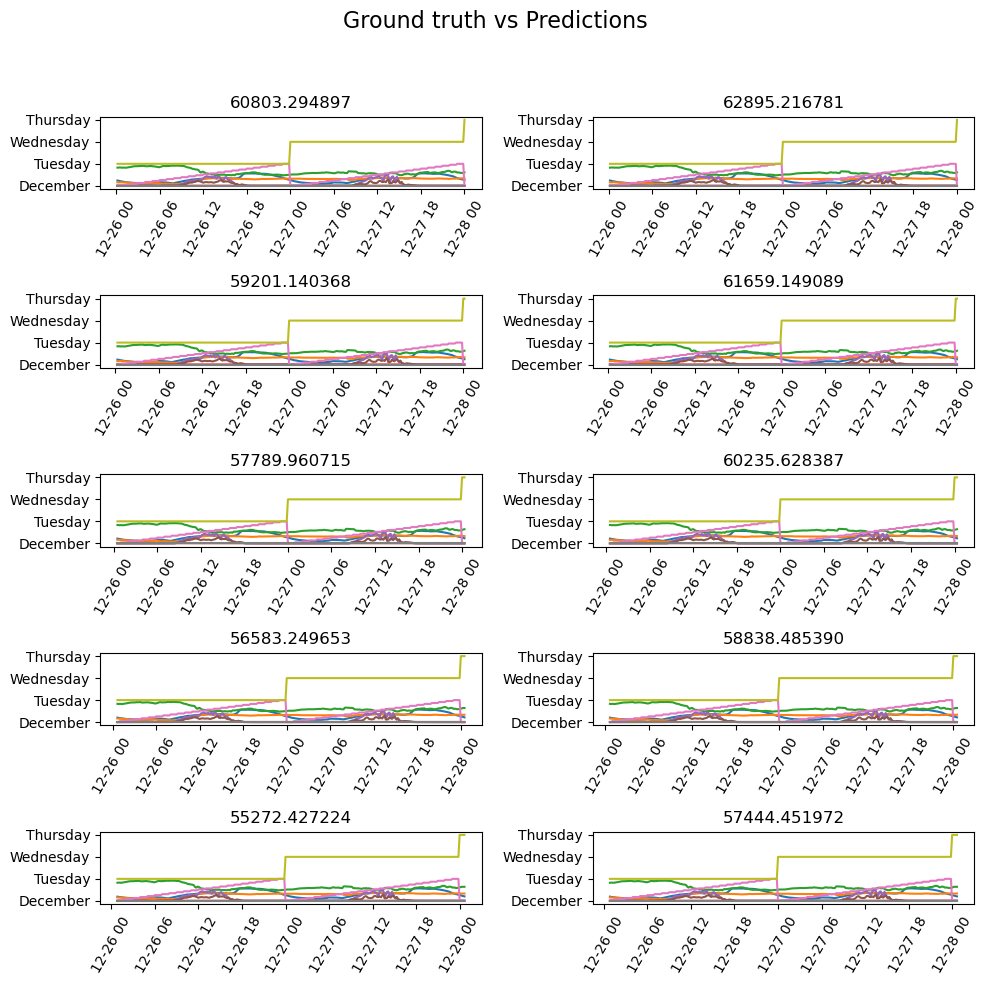

In [44]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

The show result above reveals the ground truth are close to the forecasted values by the trained model indicating a good fit. This is further validated by checking the model score.

In [45]:
ts_model.score()

0.9748908300226132

### Power Consumption Forecast & Validation using Multi-Step multivariate<a class="anchor" id="25"></a>

#### Forecasting Using the trained Timeseries Model <a class="anchor" id="26"></a>

The `predict` function is used to forecast for a period of the next 144 time steps after the last recorded time steps in the training dataset. In case of multi-step forecasting we do not need to specify the number of future timestep to forecast, and the predict function will automatically predict half of the sequence length used while preprocessing the data. The sequence length should be chosen keeping this in mind 

Thus during forecasting the model will use the same training data set as input and will use the last sequence length number of terms from its tail to predict the user given number of future prediction, which is 144. So it will forecast for the day of 30th December, at every 10 minutes power consumption, starting on 00:00, 00:10, 00:20 etc till 23:50 of the same day. 

In [46]:
# multistep - half of sequence length will be forecasted and the it is returned as a dataframe
sdf_forecasted = ts_model.predict(train,prediction_type='dataframe')

In [47]:
sdf_forecasted.tail()

DateTime  Temperature  Humidity  Wind Speed  \
52411  2017-12-30 23:10          NaN       NaN         NaN   
52412  2017-12-30 23:20          NaN       NaN         NaN   
52413  2017-12-30 23:30          NaN       NaN         NaN   
52414  2017-12-30 23:40          NaN       NaN         NaN   
52415  2017-12-30 23:50          NaN       NaN         NaN   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52411                    NaN            NaN                       NaN   
52412                    NaN            NaN                       NaN   
52413                    NaN            NaN                       NaN   
52414                    NaN            NaN                       NaN   
52415                    NaN            NaN                       NaN   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52411                        NaN                        NaN   
52412                        NaN                        NaN   
52413                        NaN                        NaN   
52414                        NaN                        NaN   
52415                        NaN                        NaN   

       Total Power Consumption Month weekday  hour  \
52411                      NaN   NaN     NaN   NaN   
52412                      NaN   NaN     NaN   NaN   
52413                      NaN   NaN     NaN   NaN   
52414                      NaN   NaN     NaN   NaN   
52415                      NaN   NaN     NaN   NaN   

       Total Power Consumption_results  
52411                     71509.824028  
52412                     68717.701092  
52413                     68091.691511  
52414                     65297.872970  
52415                     65227.342731

In [48]:
sdf_forecasted.shape

(52416, 14)

In [49]:
train.shape

(52272, 13)

In [50]:
test.shape

(144, 13)

In [51]:
test.tail()

DateTime  Temperature  Humidity  Wind Speed  \
52411 2017-12-30 23:10:00        7.010      72.4       0.080   
52412 2017-12-30 23:20:00        6.947      72.6       0.082   
52413 2017-12-30 23:30:00        6.900      72.8       0.086   
52414 2017-12-30 23:40:00        6.758      73.0       0.080   
52415 2017-12-30 23:50:00        6.580      74.1       0.081   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52411                  0.040          0.096               31160.45627   
52412                  0.051          0.093               30430.41825   
52413                  0.084          0.074               29590.87452   
52414                  0.066          0.089               28958.17490   
52415                  0.062          0.111               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52411                26857.31820                14780.31212   
52412                26124.57809                14428.81152   
52413                25277.69254                13806.48259   
52414                24692.23688                13512.60504   
52415                24055.23167                13345.49820   

       Total Power Consumption     Month   weekday  hour  
52411              72798.08659  December  Saturday  23.0  
52412              70983.80786  December  Saturday  23.0  
52413              68675.04965  December  Saturday  23.0  
52414              67163.01682  December  Saturday  23.0  
52415              65750.53976  December  Saturday  23.0

#### Estimate model metrics for validation <a class="anchor" id="27"></a>

The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 144 time steps set aside at the beginning.

In [52]:
sdf_forecasted_slice_test = sdf_forecasted.tail(test_size).copy()
sdf_forecasted_slice_test = sdf_forecasted_slice_test[['DateTime','Total Power Consumption_results']]
sdf_forecasted_slice_test['DateTime'] = pd.to_datetime(sdf_forecasted_slice_test['DateTime'].astype(str))
sdf_forecasted_slice_test['DateTime'] = pd.to_datetime(sdf_forecasted_slice_test['DateTime'])
sdf_forecasted_slice_test.tail(2)

DateTime  Total Power Consumption_results
52414 2017-12-30 23:40:00                     65297.872970
52415 2017-12-30 23:50:00                     65227.342731

In [53]:
sdf_forecasted_slice_test.shape

(144, 2)

In [54]:
sdf_forecasted_slice_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 52272 to 52415
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DateTime                         144 non-null    datetime64[ns]
 1   Total Power Consumption_results  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [55]:
new_forecast = test[['Total Power Consumption','DateTime']]
new_forecast.tail(2)

Total Power Consumption            DateTime
52414              67163.01682 2017-12-30 23:40:00
52415              65750.53976 2017-12-30 23:50:00

In [56]:
df_merge = pd.merge(sdf_forecasted_slice_test, new_forecast)
df_merge.head(5)

DateTime  Total Power Consumption_results  \
0 2017-12-30 00:00:00                     63417.956993   
1 2017-12-30 00:10:00                     60541.011661   
2 2017-12-30 00:20:00                     59654.293957   
3 2017-12-30 00:30:00                     58355.002520   
4 2017-12-30 00:40:00                     56260.448673   

   Total Power Consumption  
0              65061.74921  
1              63079.20846  
2              61256.28975  
3              60136.79086  
4              58771.21664

In [57]:
# bi-lstm
r2_test = r2_score(df_merge['Total Power Consumption'],df_merge['Total Power Consumption_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.96


The r-squared value has improved compared to one step univariate method.

## One- step multivariate Forecasting <a class="anchor" id="29"></a>

Finally we will try out one more option of multivariate forecasting but with one step instead of multistep, to see if this is better than the multi-step forecasting, while using mulitple variables. 

This combines both the one-step and multivariate approaches.

This involves predicting a single timestep in future in a time series, but instead of using just one variable's historical data, it would considers the multiple variables as used in the previous step. This means that it takes into account the past values of several different factors of temperature, humidity, wind speed etc., when making a single-step prediction. As suggestd earlier multivariate approach is useful when there are multiple variables that may collectively influence the future value being predicted.

### Timeseries Data Preparation <a class="anchor" id="30"></a>   
Data prepration for timeseries consists of first formatting the input dataframe to be used for forecasting uisng One step Multivariates, followed by splitting the dataset into train and test.

#### Formatting the input dataframe <a class="anchor" id="31"></a>  

The input dataframe to be used for forecasting, once a one-step multivariate forecasting model is trained should be properly formatted. For this dataframe, we need to fill the to-be-forecasted variable with NaN values for the number of timsesteps to be predicted. Meanwhile, the corresponding multivariate data for those future timestep should be present for forecasting. This is created as follows:

In [58]:
# Formatting input dataframe to be used for forecasting uisng One step Multivariate
city_power_consumption_df['pred_Total Power Consumption'] = city_power_consumption_df['Total Power Consumption']
city_power_consumption_df.iloc[-test_size:, city_power_consumption_df.columns.get_loc('pred_Total Power Consumption')] = np.nan

#### Train - Test split of timeseries dataset <a class="anchor" id="32"></a>

First, we will set aside the 144 (6 x 24) data points as the test set, while the remaining data will be used for training. Here the train data would be same as earlier. However the test data will have NaN values for the forecast variable. 

In [59]:
train, test = train_test_split(city_power_consumption_df, test_size = test_size, shuffle=False)

In [60]:
# visualize the train data
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  \
52270              67976.01881  December  Friday  23.0   
52271              66688.25950  December  Friday  23.0   

       pred_Total Power Consumption  
52270                   67976.01881  
52271                   66688.25950

In [61]:
train.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'Total Power Consumption', 'Month', 'weekday', 'hour',
       'pred_Total Power Consumption'],
      dtype='object')

In [62]:
# visualize the test data
test.head(2)

DateTime  Temperature  Humidity  Wind Speed  \
52272 2017-12-30 00:00:00        13.17     52.67       0.077   
52273 2017-12-30 00:10:00        13.07     52.67       0.077   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52272                  0.062          0.126               27692.77567   
52273                  0.037          0.111               26792.39544   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52272                24611.23044                 12757.7431   
52273                23874.80822                 12412.0048   

       Total Power Consumption     Month   weekday  hour  \
52272              65061.74921  December  Saturday   0.0   
52273              63079.20846  December  Saturday   0.0   

       pred_Total Power Consumption  
52272                           NaN  
52273                           NaN

Here we can see that the test data that we will use in the predict function for forecasting, has the forecast variable filled with NaN values, with the corresponding multivariates for the future timesteps that will be forecasted. 

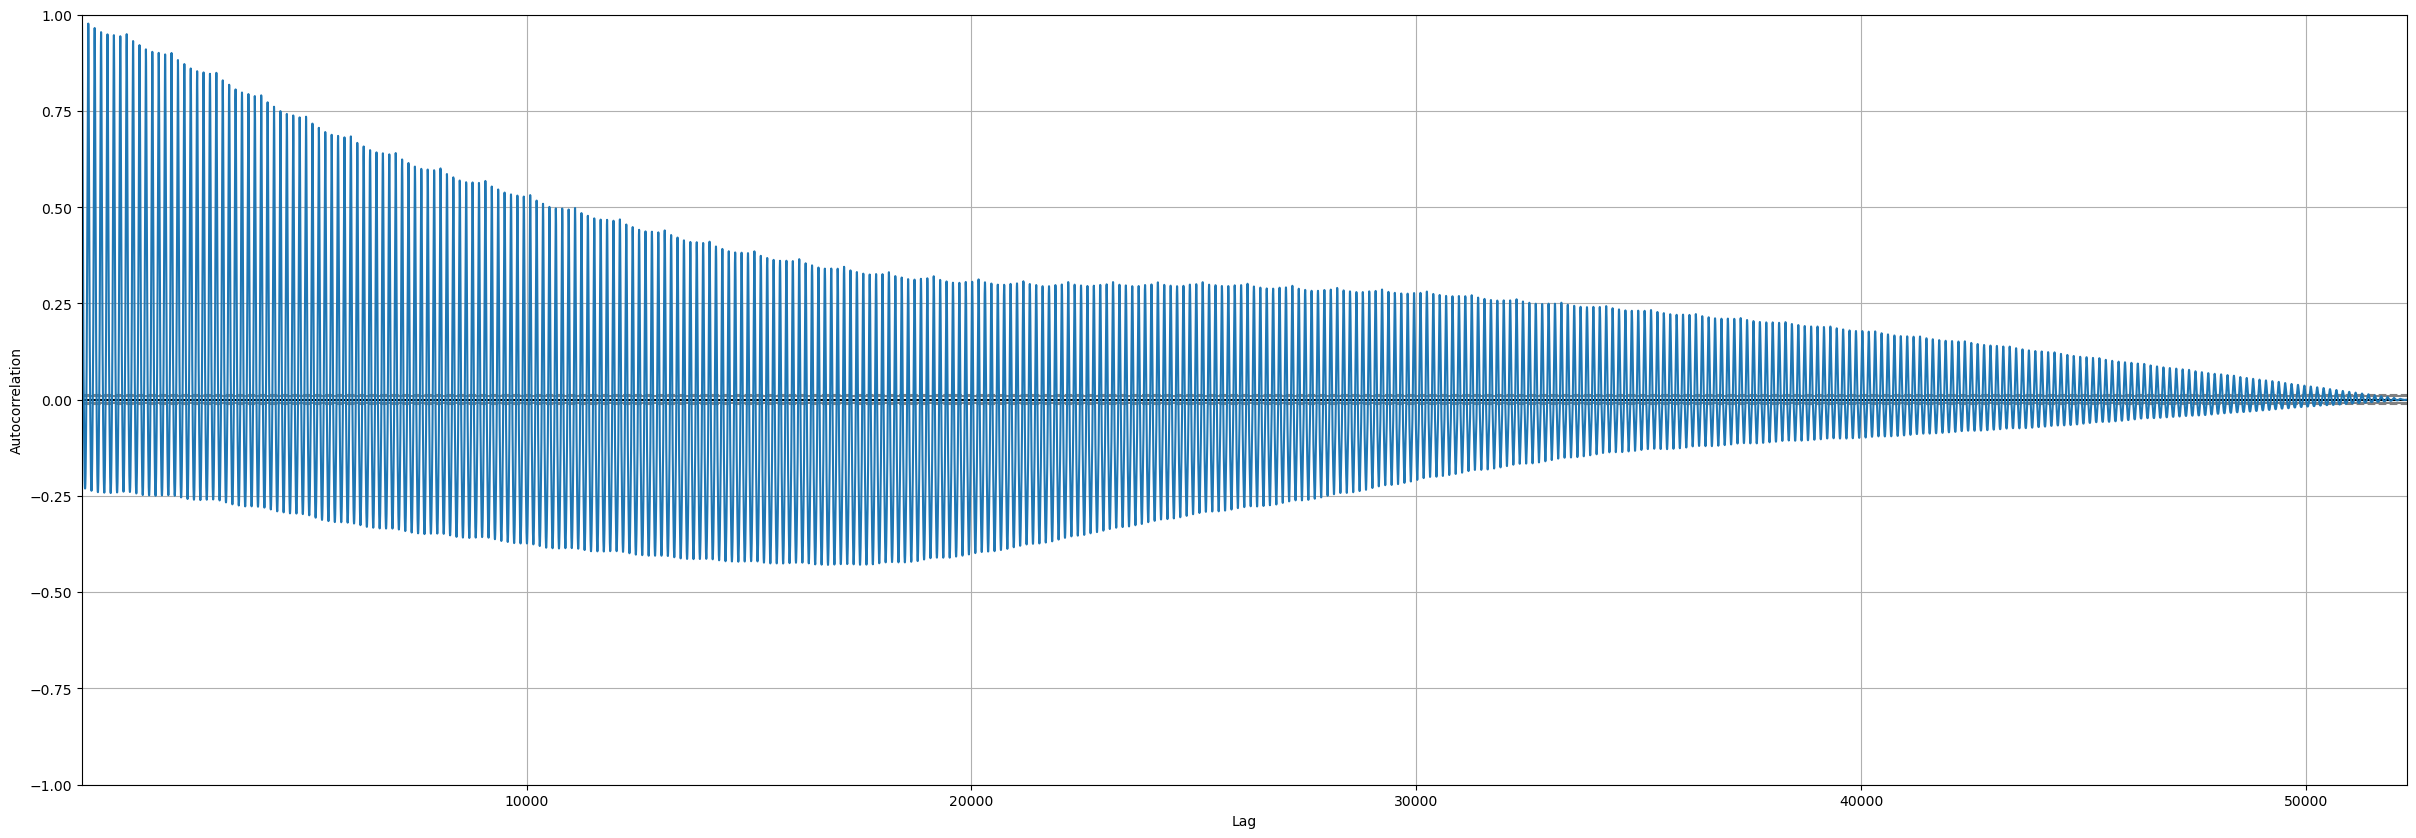

In [63]:
plt.figure(figsize=(30,10))
autocorrelation_plot(train["pred_Total Power Consumption"])
plt.show()

### Model Building <a class="anchor" id="33"></a>

Once the dataset is divided into the training and test dataset, the training data is ready to be used for modeling.

#### Data Preprocessing <a class="anchor" id="34"></a>

Here we will be using the same additional multivariates as used before, with month and weekday as categorical variables. And as earlier we will forecast the 144 timesteps of future electricity usage for every 10 minutes using these explanatory variables.

In [64]:
# one step multivariate
preprocessors = [("Temperature","Humidity","Wind Speed","general diffuse flows","diffuse flows", 
                  'hour',"pred_Total Power Consumption", MinMaxScaler())]

data = prepare_tabulardata(train, variable_predict="pred_Total Power Consumption",                            
                           explanatory_variables=["Temperature","Humidity","Wind Speed", "general diffuse flows",
                                                  "diffuse flows", ('Month',True), ('weekday',True),"hour"],
                           index_field="DateTime", preprocessors=preprocessors)

C:\Users\Supratim\AppData\Local\ESRI\conda\envs\certifica2.2_5sep23\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



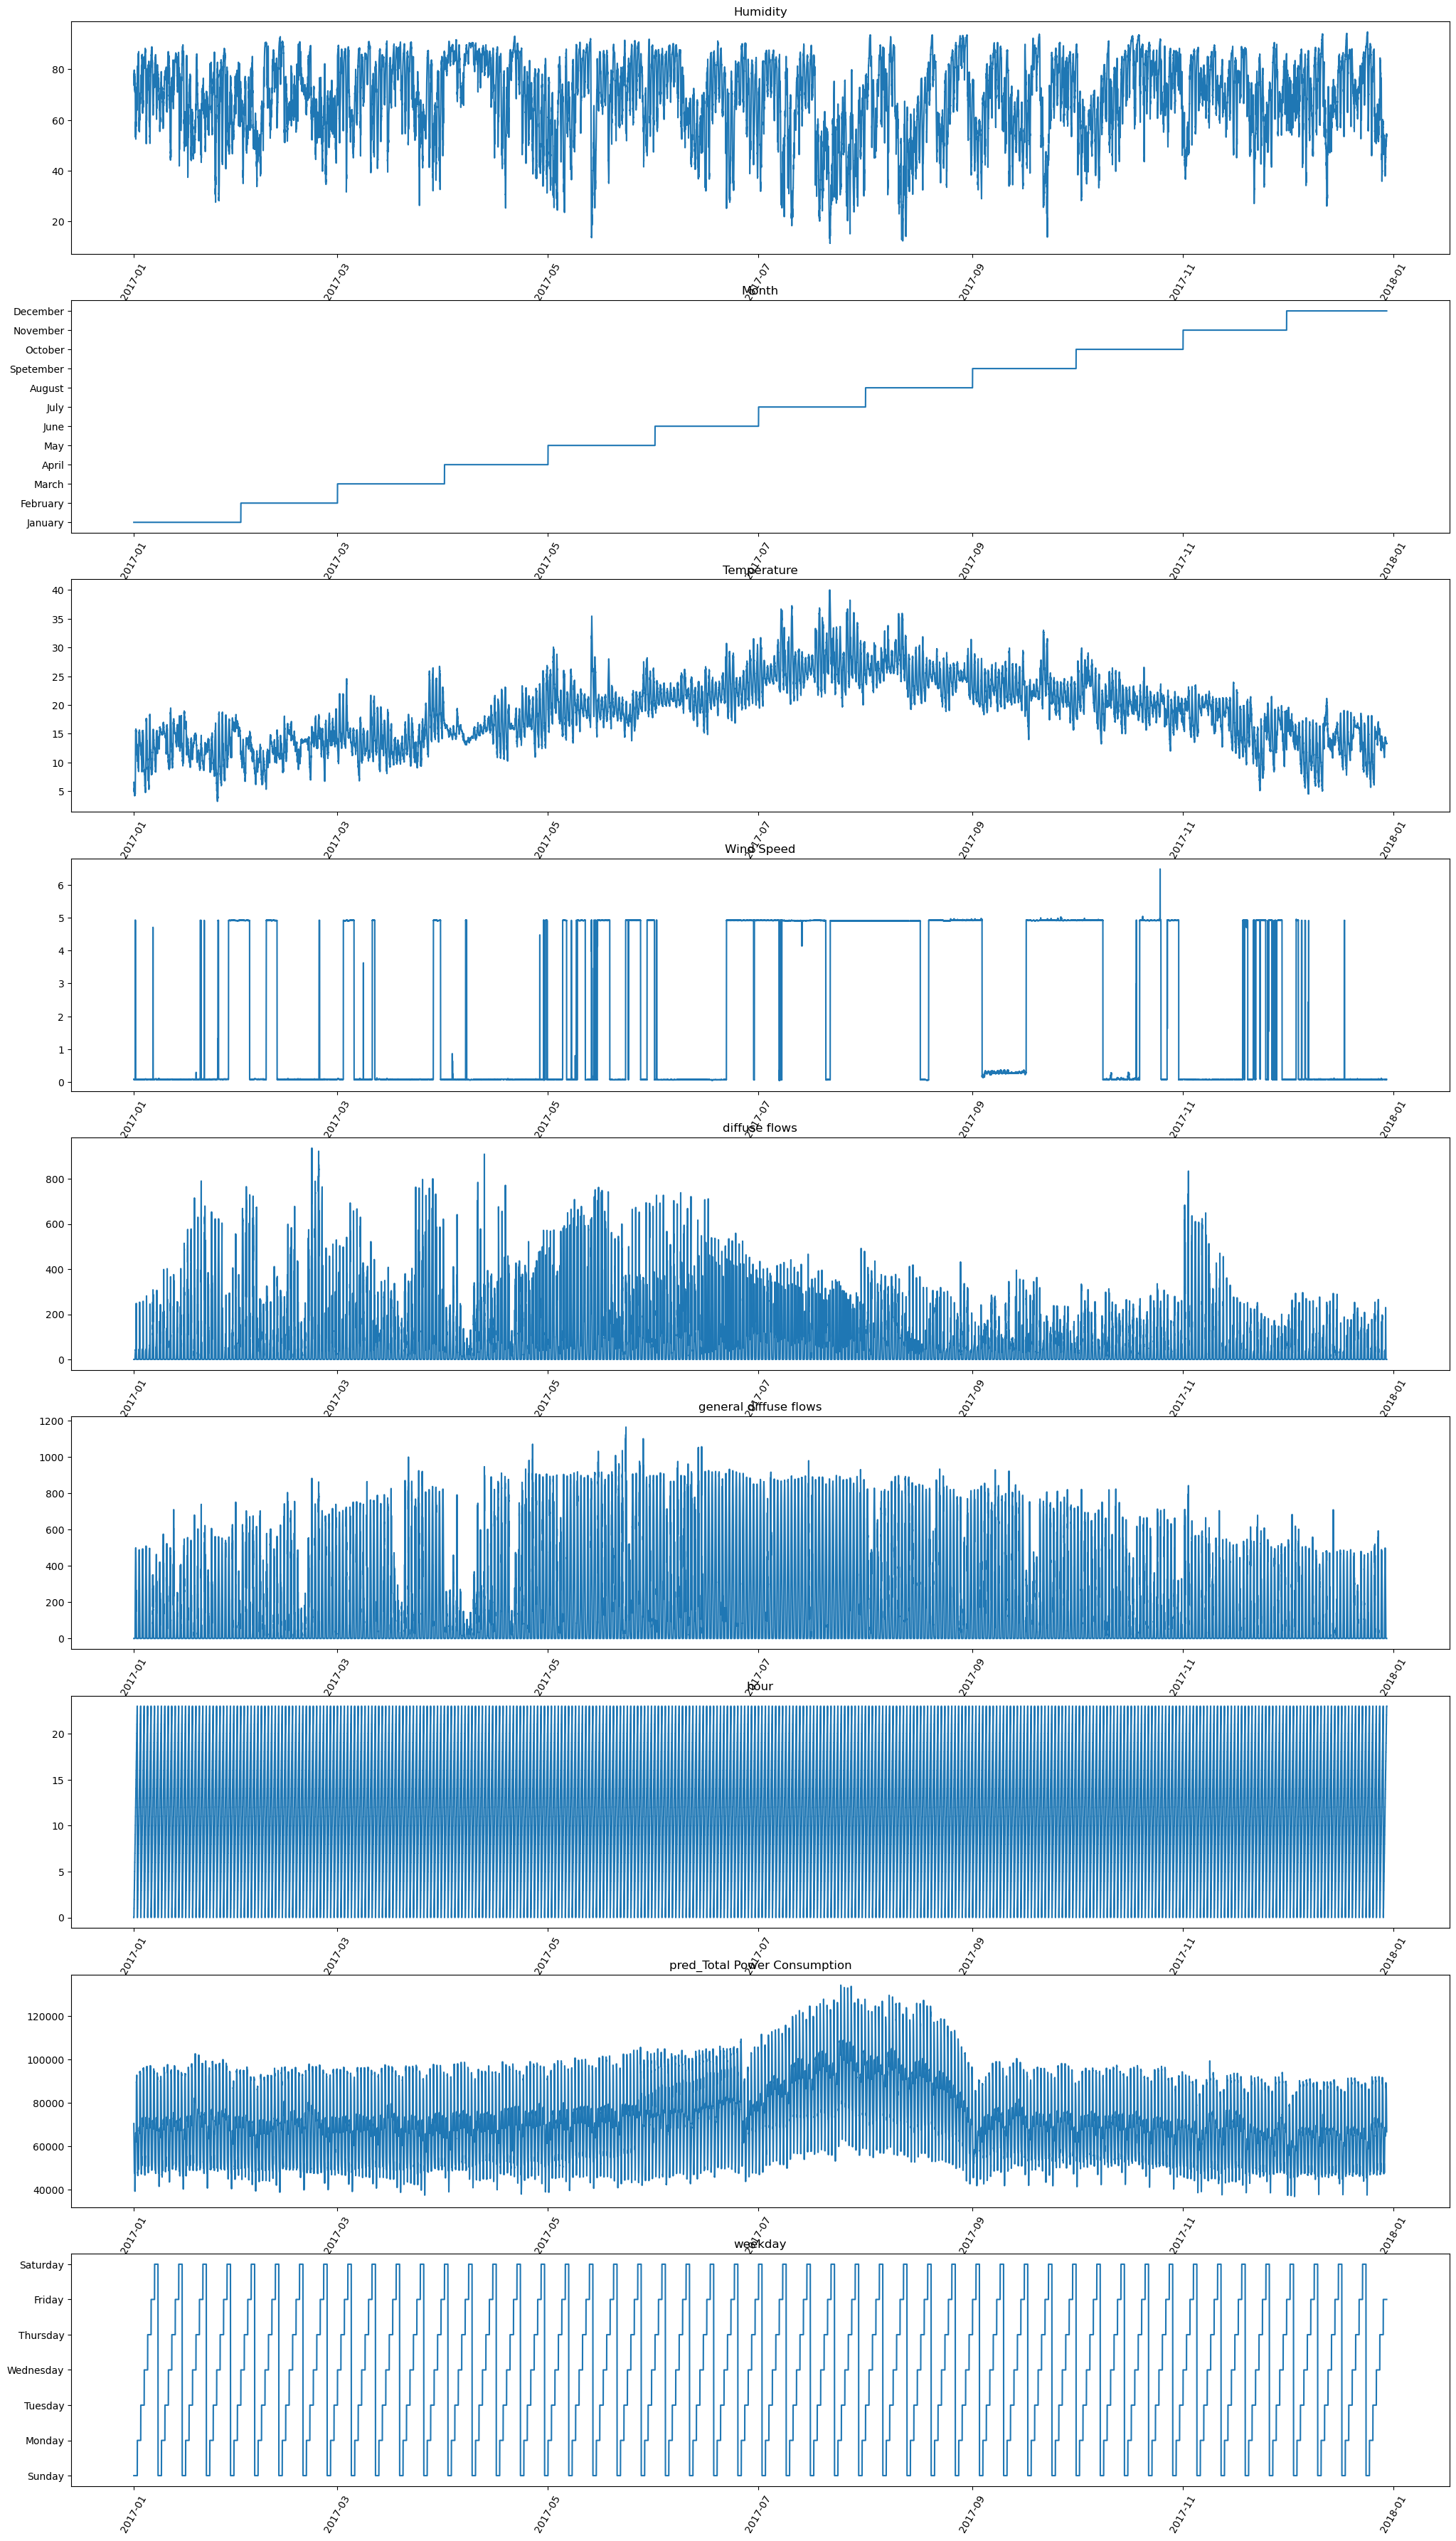

In [65]:
# # Visualize the data distibution of all the variables
data.show_batch(graph=True)

In [66]:
data.show_batch()

Humidity     Month  Temperature  Wind Speed  diffuse flows  \
19770      78.8       May        18.86       4.916         85.300   
28061      77.2      July        25.66       4.913          0.207   
33214      71.8    August        27.75       4.923        163.800   
34775      81.0    August        27.23       4.920        244.300   
50228      70.6  December        15.00       0.082          0.145   

       general diffuse flows  hour  pred_Total Power Consumption    weekday  
19770                 94.800   7.0                   53258.85754   Thursday  
28061                  0.234  20.0                  116044.38323     Friday  
33214                700.000  15.0                   91241.08204   Saturday  
34775                398.200  11.0                   76922.19575  Wednesday  
50228                  0.051  19.0                   86624.92361     Friday

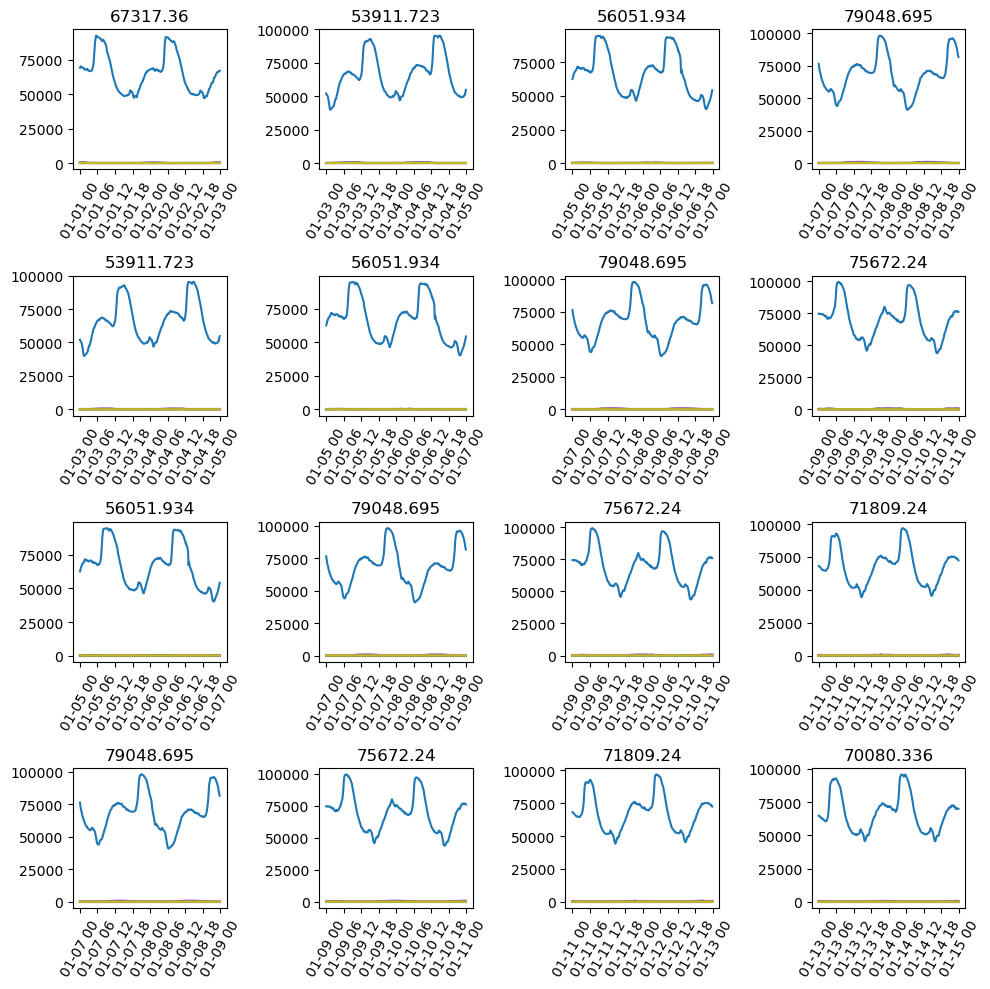

In [67]:
seq_len = 288
data.show_batch(rows=4,seq_len=seq_len)

#### One-step multivariate model initialization <a class="anchor" id="35"></a>

Here as in the first method we will initialize a ones-tep model, with the input paramter of data, sequence length and model architecture. For the model architecture we will use InceptionTime which is a specifically designed backbone for time series. USer can experiment with the various optio available. The difference here is in the preparation of the data which has the multivariates.

In [68]:
# one step - multivariate
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='InceptionTime')

#### Learning Rate Search <a class="anchor" id="36"></a>

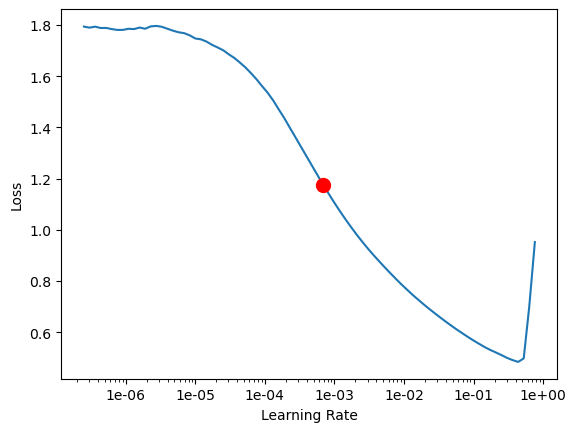

In [69]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()

### Model Training <a class="anchor" id="37"></a>

Finally, we will train the model using `model.fit`, providing the number of epochs and the estimated learning rate suggested by `lr_find` in the previous step. As previously, we will train it for two epochs. You can increase the epochs and train it more.

In [70]:
ts_model.fit(2, lr=l_rate, early_stopping=True)

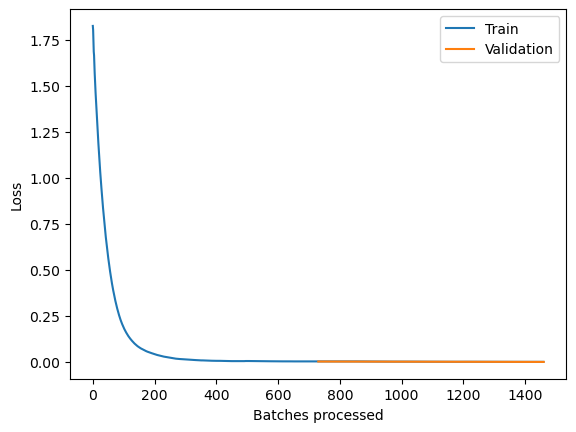

In [71]:
ts_model.plot_losses()

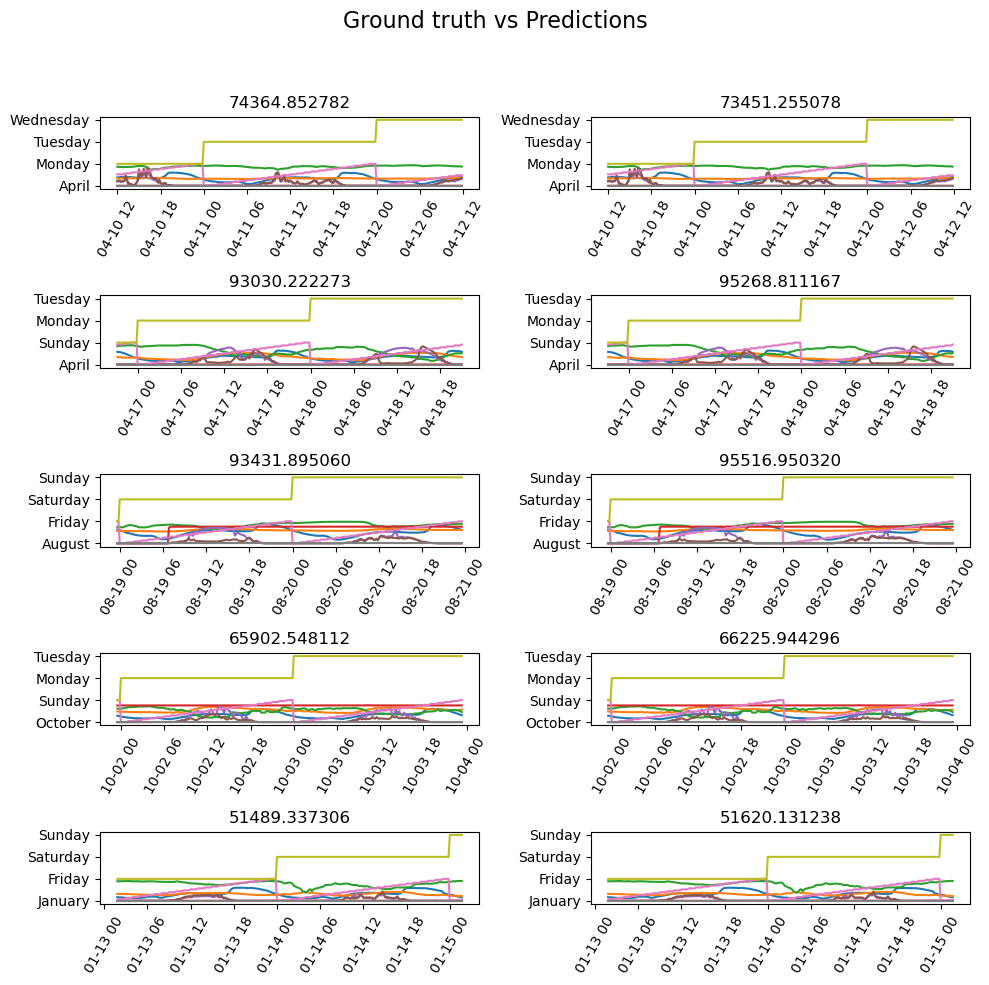

In [72]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

Here we can see the ground truth are close to the forecasted values by the trained model indicating a good fit. This is further validated by checking the model score.

In [73]:
ts_model.score()

0.9871028732991028

## Power Consumption Forecast & Validation using One-Step Multivariate <a class="anchor" id="38"></a>

#### Forecasting Using the trained Timeseries Model <a class="anchor" id="39"></a>

The `predict` function is used to forecast for a period of the next 144 time steps after the last recorded time steps in the training dataset. In the predict function we just need to input the dataset that we prepared earlier, wwith to be forecasted rows with NaN values. Thus here we do not need to specify the number of time steps to forecast, and it would automatically forecast for the NaN filled rows. So it will forecast for the day of 30th December, at every 10 minutes power consumption, starting on 00:00, 00:10, 00:20 etc till 23:50 of the same day.

In [74]:
# forecasted values is returned as a dataframe
sdf_forecasted = ts_model.predict(city_power_consumption_df, prediction_type='dataframe')

In [75]:
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  \
52270              67976.01881  December  Friday  23.0   
52271              66688.25950  December  Friday  23.0   

       pred_Total Power Consumption  
52270                   67976.01881  
52271                   66688.25950

In [76]:
sdf_forecasted.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52414 2017-12-30 23:40:00        6.758      73.0       0.080   
52415 2017-12-30 23:50:00        6.580      74.1       0.081   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52414                  0.066          0.089               28958.17490   
52415                  0.062          0.111               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52414                24692.23688                13512.60504   
52415                24055.23167                13345.49820   

       Total Power Consumption     Month   weekday  hour  \
52414              67163.01682  December  Saturday  23.0   
52415              65750.53976  December  Saturday  23.0   

       pred_Total Power Consumption  pred_Total Power Consumption_results  
52414                           NaN                          66319.951709  
52415                           NaN                          64146.867208

#### Estimate model metrics for validation <a class="anchor" id="40"></a>

The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 144 time steps set aside earlier.

In [77]:
sdf_forecasted_slice = sdf_forecasted.tail(test_size).copy()
sdf_forecasted_final = sdf_forecasted_slice.loc[:, ['DateTime','Total Power Consumption','pred_Total Power Consumption_results']]
sdf_forecasted_final.head(2)

DateTime  Total Power Consumption  \
52272 2017-12-30 00:00:00              65061.74921   
52273 2017-12-30 00:10:00              63079.20846   

       pred_Total Power Consumption_results  
52272                          61986.139726  
52273                          60770.021534

In [78]:
r2_test = r2_score(sdf_forecasted_final['Total Power Consumption'],sdf_forecasted_final['pred_Total Power Consumption_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.97


The r-squared value has improved further compared to multi-step multivariate method. This suggests that both the one-step and multi-step multivariate approaches outperform the univariate method, which is expected.

### Result Visualization <a class="anchor" id="41"></a>

Finally, the actual and forecasted values are plotted to visualize their distribution. The blue lines indicating forecasted values and orange line showing the actual values are a close match.

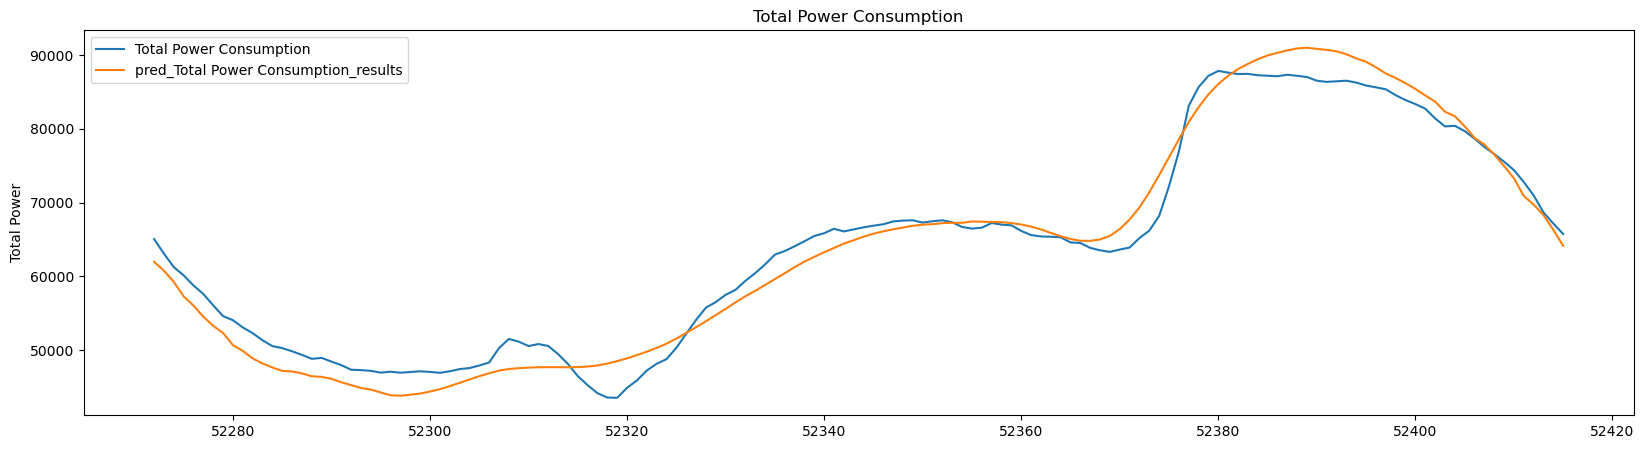

In [79]:
# Plot the "Total Power Consumption" and "pred_Total Power Consumption_results" columns aagint the index
sdf_forecasted_final.plot(y=['Total Power Consumption', 'pred_Total Power Consumption_results'], kind="line", figsize=(20, 5))
plt.ylabel("Total Power")
plt.title( 'Total Power Consumption')
# Display the plot
plt.show()

## Conclusion <a class="anchor" id="42"></a>

In the deep learning time series notebook, we utilized newly implemented methods from the `arcgis.learn` library to forecast power consumption for the city of Tetouan at 10-minute intervals for an entire day. This involved predicting 144 future time steps.

These approaches included one-step univariate, one-step multivariate, and multi-step multivariate methods. The notebook provided detailed explanations for each methodology, including data processing and application for time series forecasting.

Furthermore, the notebook introduced several novel deep learning architectures including some specially designed for modelling timesereis data, that significantly enhanced the model's performance, evident in the high accuracy of the forecasted values compared to the actual ones.

Overall, the notebook demonstrated the improvement of both multivariate approaches over the univariate approach, aligning with expectations.

Time series modeling is typically intricate, often requiring fine-tuning of numerous hyperparameters to achieve accurate results. However, this current implementation in the time series module encapsulates and simplifies these complexities, offering users an intuitive and flexible approach.

## Data resources <a class="anchor" id="43"></a>

| Dataset | Citation | Link |
| -| - |-|
|Power consumption of Tetouan city|Salam, A., & El Hibaoui, A. (2018, December). Comparison of Machine Learning Algorithms for the Power Consumption Prediction:-Case Study of Tetouan city“. In 2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1-5). IEEE.|https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city|

                                                           ------End-----